# Modeling 111001001 drop features

In this notebook, we're specifically working on the dataset formed by dropping (31, 496, 524, 917, 1299) and the features ('LogGrLivArea', 'TotalHouseArea', 'LivAreaWt', 'AreasSum'), since that resulted in the lowest validation error.

In [86]:
import itertools
import numpy as np
import pandas as pd
import scipy
from scipy import optimize

pd.set_option('display.precision',20)
pd.set_option('display.max_colwidth',100)

from sklearn import linear_model, svm, tree
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_val_score, \
                                    GridSearchCV, RandomizedSearchCV, ShuffleSplit
from sklearn.neural_network import MLPRegressor
    
    
    
import xgboost as xgb

from time import time
from scipy.stats import randint as sp_randint

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from matplotlib import pyplot
rcParams['figure.figsize'] = 12, 4
%matplotlib inline

In [2]:
# def to compare goodness of fit on training set
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [4]:
# run randomized search
def random_search(regr, param_dist, n_iter_search): 
    rs = RandomizedSearchCV(regr, param_distributions=param_dist, scoring = 'neg_mean_squared_error',
                                   n_jobs=-1, n_iter=n_iter_search, cv=kfold) #, verbose = 4)
    start = time()
    rs.fit(x_train, y_train)
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
    report(rs.cv_results_)

In [5]:
# run single parameter search (for ridge or lasso)
def single_search(regr, params):
    regr_results_df = pd.DataFrame(dtype = 'float64')
    count = 0
    for k, v in params.items():
        for val in v:
            regr.set_params(**{k: val})
            regr_results_df.loc[count, k] = val
            results = cross_val_score(regr, x_train, y_train, cv=kfold, scoring = 'neg_mean_squared_error')
            (regr_results_df.loc[count, 'RMSE'], regr_results_df.loc[count, 'std dev']) = \
                    (np.sqrt(-results.mean()), np.sqrt(results.std()))
            count += 1
    return regr_results_df

In [18]:
# test against validation set
def validate(regr):
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_validation)
    return rmse(y_validation, y_pred)

In [6]:
# Cross-validation sets
kfold = KFold(n_splits=10, random_state=7)

In [8]:
df = pd.read_csv("./input/train_tidy_111001001.csv")
df.drop(['LogGrLivArea', 'TotalHouseArea', 'LivAreaWt', 'AreasSum'], axis=1, inplace=True)

In [11]:
ss = ShuffleSplit(n_splits=1, test_size=0.20, random_state=71)

X = df.values

for train_idx, validation_idx in ss.split(X):
    train_df = df.iloc[train_idx]
    validation_df = df.iloc[validation_idx]
    
y_validation = validation_df['SalePrice'].values
x_validation = validation_df.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values
y_train = train_df['SalePrice'].values
x_train = train_df.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values

## Ridge regression

In [12]:
ridge_regr = linear_model.Ridge()

In [13]:
ridge_param = {'alpha': scipy.stats.expon(scale=10)}
random_search(ridge_regr, ridge_param, 20)

RandomizedSearchCV took 2.04 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.013 (std: 0.005)
Parameters: {'alpha': 6.7312391266006069}

Model with rank: 2
Mean validation score: -0.013 (std: 0.005)
Parameters: {'alpha': 6.2486033106129115}

Model with rank: 3
Mean validation score: -0.013 (std: 0.005)
Parameters: {'alpha': 5.7226519586614346}



,alpha,RMSE,std dev
0,1.0,0.11524302234147687507,0.07137743285652593805
1,2.0,0.11403820902710801177,0.07154230677449920084
13,14.0,0.11349622872123382722,0.07215616844206898528
2,3.0,0.11342340606481733645,0.07154287047686351542
12,13.0,0.11333389982566394183,0.07207168123810288318
11,12.0,0.11318377683821694013,0.07198868542885882016
3,4.0,0.11307128444563065151,0.07153887392741062334
10,11.0,0.11304862560042373831,0.07190790960434584322
9,10.0,0.11293203025972541054,0.07183032329746907862
4,5.0,0.11287332884291881308,0.07155269290129599724


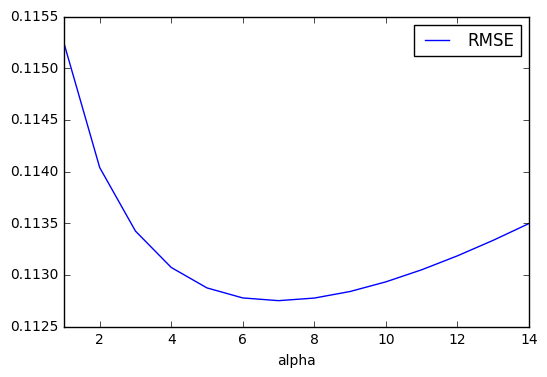

In [15]:
ridge_params = {'alpha': np.arange(1, 15, 1).tolist()}
ridge_df = single_search(ridge_regr, ridge_params)
ridge_df.plot(x = ['alpha'], y = ['RMSE'])
ridge_df.sort_values(['RMSE'], ascending = False)

In [16]:
ridge_regr = linear_model.Ridge(alpha = 7)

In [19]:
validate(ridge_regr)

0.10755546853975097

## Lasso

In [20]:
lasso_regr = linear_model.Lasso(max_iter=50000)

In [21]:
lasso_param = {'alpha': scipy.stats.expon(scale=0.001)}
random_search(lasso_regr, lasso_param, 20)

RandomizedSearchCV took 10.14 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.012 (std: 0.005)
Parameters: {'alpha': 0.00038248084945444617}

Model with rank: 2
Mean validation score: -0.012 (std: 0.005)
Parameters: {'alpha': 0.00038701671035534183}

Model with rank: 3
Mean validation score: -0.012 (std: 0.005)
Parameters: {'alpha': 0.00031437190597278624}



,alpha,RMSE,std dev
0,0.00010000000000000000,0.11186051542275779469,0.07302904436389211218
5,0.00060000000000000006,0.11014032554024717758,0.07262730848349076285
4,0.00050000000000000001,0.10966456973851299028,0.07249142024191483624
1,0.00020000000000000001,0.10959454572557245089,0.07329275427256819186
3,0.00040000000000000002,0.10934067380193988883,0.07253435889172187012
2,0.00030000000000000003,0.10932793731334025655,0.07302795453317843799


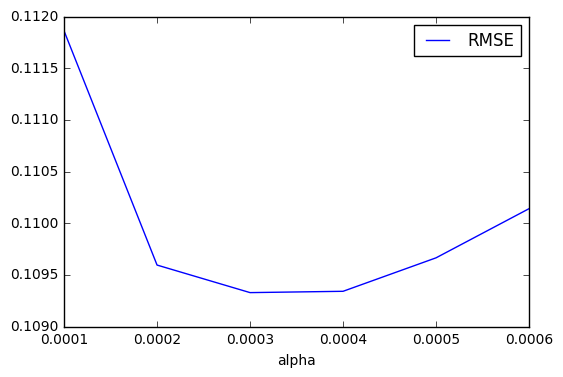

In [22]:
lasso_params = {'alpha': np.arange(0.0001, 0.0007, 0.0001).tolist()}
lasso_df = single_search(lasso_regr, lasso_params)
lasso_df.plot(x = ['alpha'], y = ['RMSE'])
lasso_df.sort_values(['RMSE'], ascending = False)

In [23]:
lasso_regr = linear_model.Lasso(alpha=0.0003, max_iter=50000)

In [24]:
validate(lasso_regr)

0.1018653774236518

## Lasso LARS

In [25]:
lassolars_regr = linear_model.LassoLars(max_iter=50000)

In [26]:
lassolars_param = {'alpha': scipy.stats.expon(scale=0.0001)}
random_search(lassolars_regr, lassolars_param, 20)

/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 215 iterations, i.e. alpha=2.996e-05, with an active set of 177 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 221 iterations, i.e. alpha=2.588e-05, with an active set of 179 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 219 iterations, i.e. alpha=2.470e-05, with an active set of 179 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model

RandomizedSearchCV took 4.90 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.011 (std: 0.005)
Parameters: {'alpha': 0.00010069132797039688}

Model with rank: 2
Mean validation score: -0.011 (std: 0.005)
Parameters: {'alpha': 0.00010137611840597633}

Model with rank: 3
Mean validation score: -0.011 (std: 0.005)
Parameters: {'alpha': 0.00011498916390164866}



,alpha,RMSE,std dev
5,0.00013000000000000002,0.10716145912983648936,0.07110954727988359758
0,0.00008000000000000001,0.10716102745380604033,0.07051981145472104029
4,0.00012000000000000000,0.10706671445404572496,0.07095304470442918843
1,0.00009000000000000001,0.10705312238979421136,0.07051122740851901993
3,0.00011000000000000000,0.10704260149006375458,0.07080356020928518790
2,0.00010000000000000000,0.10701977033640160120,0.07060675949776946958


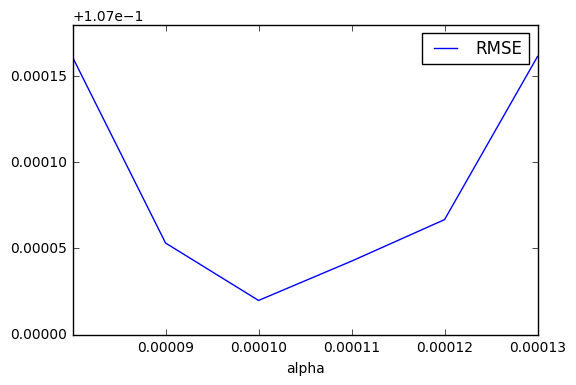

In [27]:
lassolars_params = {'alpha': np.arange(0.00008, 0.00014, 0.00001).tolist()}
lassolars_df = single_search(lassolars_regr, lassolars_params)
lassolars_df.plot(x = ['alpha'], y = ['RMSE'])
lassolars_df.sort_values(['RMSE'], ascending = False)

In [28]:
lassolars_regr = linear_model.LassoLars(alpha=0.0001, max_iter=50000)

In [29]:
validate(lassolars_regr)

0.10025529872098059

## Elastic Net

In [30]:
elnet_regr = linear_model.ElasticNet(max_iter=15000, random_state=7)

In [31]:
elnet_param =  {'alpha': scipy.stats.expon(scale=0.001), 'l1_ratio': scipy.stats.truncnorm(0, 1, loc=0.5, scale=0.25)}
random_search(elnet_regr, elnet_param, 20)

RandomizedSearchCV took 23.76 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.012 (std: 0.005)
Parameters: {'alpha': 0.00038129682085003843, 'l1_ratio': 0.71653865623370994}

Model with rank: 2
Mean validation score: -0.012 (std: 0.005)
Parameters: {'alpha': 0.00051670744700143428, 'l1_ratio': 0.72152101309055483}

Model with rank: 3
Mean validation score: -0.012 (std: 0.005)
Parameters: {'alpha': 0.00028506483734454095, 'l1_ratio': 0.70725383912287643}



,alpha,RMSE,std dev
0,0.00010000000000000000,0.11324082385411007867,0.07259278853682168964
1,0.00020000000000000001,0.11042340367278377644,0.07326446175616713186
6,0.00070000000000000010,0.11012421331421168302,0.07251701423087983378
5,0.00060000000000000006,0.10981939099946205762,0.07246999512213876671
4,0.00050000000000000001,0.10963184780529255935,0.07259002660183228040
2,0.00030000000000000003,0.10959920564361509687,0.07323944937629639496
3,0.00040000000000000002,0.10948564662941652481,0.07297074512812558311


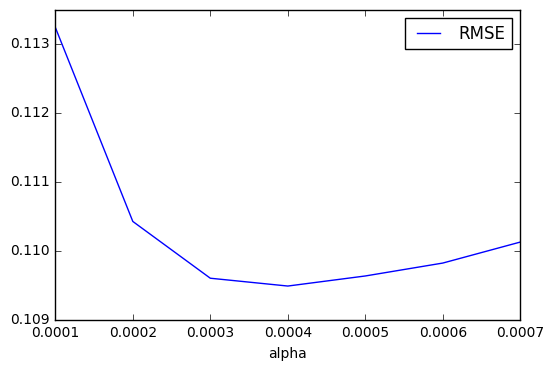

In [34]:
elnet_regr = linear_model.ElasticNet(alpha=0.00038, l1_ratio=0.72, max_iter=15000, random_state=7)
elnet_params = {'alpha': np.arange(0.0001, 0.0008, 0.0001).tolist()}
elnet_df = single_search(elnet_regr, elnet_params)
elnet_df.plot(x = ['alpha'], y = ['RMSE'])
elnet_df.sort_values(['RMSE'], ascending = False)

,l1_ratio,RMSE,std dev
0,0.84999999999999997780,0.10944465402122376119,0.07271190162235939558
1,0.85999999999999998668,0.10943293883840533864,0.07268670093685304645
2,0.86999999999999999556,0.10941962323461508488,0.07266969859264037213
3,0.88000000000000000444,0.10940482271305025652,0.07265345112237715786
4,0.89000000000000001332,0.10939222470283613275,0.07263671006042193845
5,0.90000000000000002220,0.10938336711000763712,0.07262692020845663843
6,0.91000000000000003109,0.10937500633332954136,0.07261982742705599958
7,0.92000000000000003997,0.10936757144201851577,0.07260434375071786461
8,0.93000000000000004885,0.10936212586209820286,0.07258905331339012001
9,0.94000000000000005773,0.10935760773770634990,0.07258288704652503254


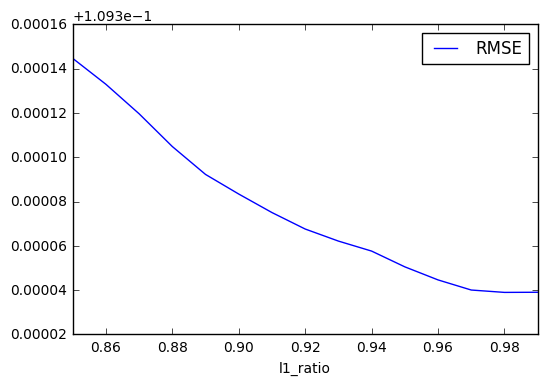

In [36]:
elnet_regr = linear_model.ElasticNet(alpha=0.0004, max_iter=15000, random_state=7)
elnet_params = {'l1_ratio': np.arange(0.85, 0.99, 0.01).tolist()}
elnet_df = single_search(elnet_regr, elnet_params)
elnet_df.plot(x = ['l1_ratio'], y = ['RMSE'])
elnet_df.sort_values(['RMSE'], ascending = False)

In [37]:
elnet_regr = linear_model.ElasticNet(alpha=0.0004, l1_ratio=0.98, max_iter=15000, random_state=7)

In [38]:
validate(elnet_regr)

0.10124023616844934

## Random Forest

In [39]:
rf_regr = RandomForestRegressor(n_jobs=-1, random_state = 7)

In [40]:
rf_param =  {'n_estimators': scipy.stats.randint(50,400), 'max_depth': scipy.stats.randint(2,20), 
             'max_features': scipy.stats.randint(5,30)}
random_search(rf_regr, rf_param, 20)

RandomizedSearchCV took 64.22 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.017 (std: 0.006)
Parameters: {'max_features': 25, 'n_estimators': 299, 'max_depth': 11}

Model with rank: 2
Mean validation score: -0.017 (std: 0.006)
Parameters: {'max_features': 21, 'n_estimators': 266, 'max_depth': 15}

Model with rank: 3
Mean validation score: -0.017 (std: 0.006)
Parameters: {'max_features': 19, 'n_estimators': 271, 'max_depth': 16}



,n_estimators,RMSE,std dev
8,330.0,0.12678870548767284809,0.07554352390187454858
9,340.0,0.12675751931229675695,0.07535985066378926567
1,260.0,0.12665500939599008690,0.07495359635980282376
7,320.0,0.12665167910062496981,0.07539330702501287340
6,310.0,0.12659813677772427387,0.07537238723288383624
0,250.0,0.12657615149685302880,0.07491559343305503882
5,300.0,0.12655275939973403831,0.07517350932599227431
2,270.0,0.12650539750654379856,0.07492973583606338250
4,290.0,0.12646526799696816701,0.07513458346090330642
3,280.0,0.12640864590212699814,0.07493523103927529627


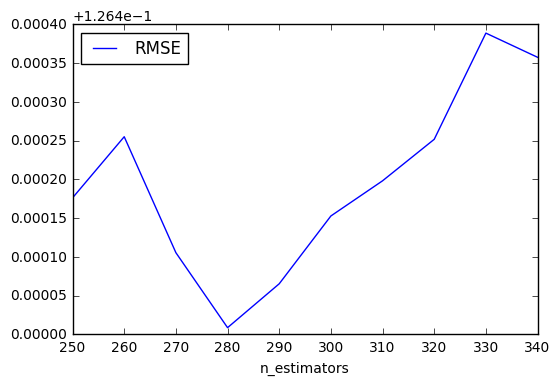

In [51]:
rf_regr = RandomForestRegressor(n_estimators = 299, max_depth = 16, max_features = 60, random_state = 7)
rf_params = {'n_estimators': np.arange(250, 350, 10).tolist()}
rf_df = single_search(rf_regr, rf_params)
rf_df.plot(x = ['n_estimators'], y = ['RMSE'])
rf_df.sort_values(['RMSE'], ascending = False)

In [52]:
rf_regr = RandomForestRegressor(n_estimators = 280, max_depth = 16, max_features = 60, random_state = 7)

In [53]:
validate(rf_regr)

0.11779392462902648

## Support Vector Regressor

In [54]:
svr_regr = svm.SVR(cache_size=200, degree=3, max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [55]:
svr_param = {'C': scipy.stats.expon(scale=1), 'gamma': scipy.stats.expon(scale=.1),
              'kernel': ['rbf']}
random_search(svr_regr, svr_param, 20)

RandomizedSearchCV took 25.74 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.018 (std: 0.006)
Parameters: {'kernel': 'rbf', 'C': 1.6787825556797566, 'gamma': 0.028742394744790241}

Model with rank: 2
Mean validation score: -0.019 (std: 0.006)
Parameters: {'kernel': 'rbf', 'C': 0.97773244346240462, 'gamma': 0.036449625636116305}

Model with rank: 3
Mean validation score: -0.025 (std: 0.008)
Parameters: {'kernel': 'rbf', 'C': 1.042070744152384, 'gamma': 0.056797413287228107}



,C,RMSE,std dev
12,3.40000000000000124345,0.11802841033934004245,0.07364570880411729081
11,3.30000000000000115463,0.11800315176870633527,0.07365276504363724164
10,3.20000000000000106581,0.11796747734409564201,0.07367808749959944836
0,2.20000000000000017764,0.11796047731149522653,0.07389946996110878519
9,3.10000000000000097700,0.11795873578086846223,0.07372525916612611419
1,2.30000000000000026645,0.11795825203182644381,0.07390773525734377347
6,2.80000000000000071054,0.11794698336115599924,0.07386734057776869755
4,2.60000000000000053291,0.11793840214822355617,0.07395391840383266913
2,2.40000000000000035527,0.11793715646218344562,0.07395065782811172106
3,2.50000000000000044409,0.11793231376612831052,0.07394965740634759643


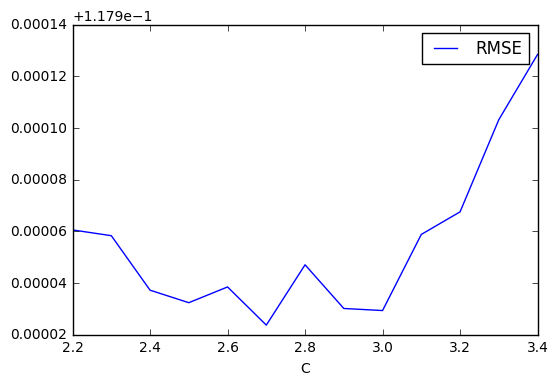

In [59]:
svr_regr = svm.SVR(C=1.7, cache_size=200, coef0=0.0, degree=3, gamma=0.005,
                        kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
svr_params = {'C': np.arange(2.2, 3.5, 0.1).tolist()}
svr_df = single_search(svr_regr, svr_params)
svr_df.plot(x = ['C'], y = ['RMSE'])
svr_df.sort_values(['RMSE'], ascending = False)

In [60]:
svr_regr = svm.SVR(C=2.7, cache_size=200, coef0=0.0, degree=3, gamma=0.005,
                        kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [61]:
validate(svr_regr)

0.11213488046486904

## Orthogonal Matching Pursuit

In [62]:
omp_regr = linear_model.OrthogonalMatchingPursuit()

In [63]:
omp_param = {'n_nonzero_coefs': scipy.stats.randint(20,100)}
random_search(omp_regr, omp_param, 20)

RandomizedSearchCV took 2.36 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.013 (std: 0.005)
Parameters: {'n_nonzero_coefs': 88}

Model with rank: 2
Mean validation score: -0.013 (std: 0.005)
Parameters: {'n_nonzero_coefs': 82}

Model with rank: 3
Mean validation score: -0.013 (std: 0.005)
Parameters: {'n_nonzero_coefs': 79}



,n_nonzero_coefs,RMSE,std dev
0,75.0,0.11570752212476714815,0.07079024122121035933
1,76.0,0.11570005977703766431,0.07088645207499462420
5,80.0,0.11559646843207441180,0.07160562161945162318
20,95.0,0.11552874240082916524,0.07167831001850719086
6,81.0,0.11552321369437934528,0.07176407575525349525
19,94.0,0.11541553078156920054,0.07127471613359941116
2,77.0,0.11540416647966511565,0.07044565476553499295
15,90.0,0.11538988015584122904,0.07176131265618135302
8,83.0,0.11537864069365215414,0.07150241359379823358
4,79.0,0.11536558563907840791,0.07134142379219987617


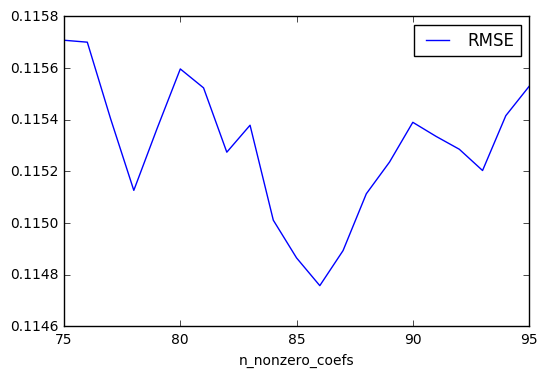

In [64]:
omp_regr = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=27)
omp_params = {'n_nonzero_coefs': np.arange(75, 96, 1).tolist()}
omp_df = single_search(omp_regr, omp_params)
omp_df.plot(x = ['n_nonzero_coefs'], y = ['RMSE'])
omp_df.sort_values(['RMSE'], ascending = False)

In [65]:
omp_regr = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=86)

In [66]:
validate(omp_regr)

0.10503915152968471

## XGBoost

In [68]:
xgb_regr = xgb.XGBRegressor(seed = 42, nthread = -1, silent = 1)
xgb_param = {'max_depth': scipy.stats.randint(1,10), # Max. Depth [1,∞]
             'min_child_weight': scipy.stats.expon(scale=1), # Min. Child Weight [0,∞]
             'gamma': scipy.stats.expon(scale=1), # Minimum Split Loss, gamma [0,∞]
             'subsample': scipy.stats.uniform(0, 1), # Subsample Ratio of the training instance [0,1]
             'colsample_bytree': scipy.stats.uniform(0, 1), # Subsample Ratio of columns [0,1]
             'reg_alpha': scipy.stats.expon(scale=1), # L1 regularization, alpha [0,∞]
             'reg_lambda': scipy.stats.expon(scale=1), # L2 regularization, lambda [0,∞]
             'learning_rate': scipy.stats.uniform(0, 1), # Step size shrinkage (learning rate) [0,1]
             'n_estimators': scipy.stats.randint(50,500) # Number of boosted trees, n_estimators
            }
random_search(xgb_regr, xgb_param, 20)

RandomizedSearchCV took 3408.96 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.016 (std: 0.006)
Parameters: {'reg_alpha': 0.27477861923587693, 'colsample_bytree': 0.92852766261854847, 'learning_rate': 0.10916721946655117, 'min_child_weight': 1.0706093479686645, 'n_estimators': 356, 'subsample': 0.64259890571509803, 'reg_lambda': 0.51995103923635744, 'max_depth': 2, 'gamma': 0.23215964444910381}

Model with rank: 2
Mean validation score: -0.018 (std: 0.006)
Parameters: {'reg_alpha': 0.57268975485615914, 'colsample_bytree': 0.70293883755181508, 'learning_rate': 0.29661284648635466, 'min_child_weight': 0.44487799748159507, 'n_estimators': 174, 'subsample': 0.26042577273383327, 'reg_lambda': 0.093892494457137723, 'max_depth': 1, 'gamma': 0.12740759227512938}

Model with rank: 3
Mean validation score: -0.019 (std: 0.008)
Parameters: {'reg_alpha': 1.875337367751988, 'colsample_bytree': 0.57981648709236677, 'learning_rate': 0.041424895556027019, 'mi

,n_estimators,RMSE,std dev
0,500.0,0.11441088721153996888,0.06690928539797064145
7,850.0,0.11439820182964799411,0.06663914593173943246
8,900.0,0.11437201083762164877,0.06666875531514795949
1,550.0,0.11436485512347960292,0.06672412306041027030
2,600.0,0.11434255542642496328,0.06663177362672116633
6,800.0,0.11431028592173612946,0.06667752699433791841
4,700.0,0.11427921637134001720,0.06669783621017087716
3,650.0,0.11425317476105738279,0.06660655898031052347
5,750.0,0.11424089799843804849,0.06668815646185449753


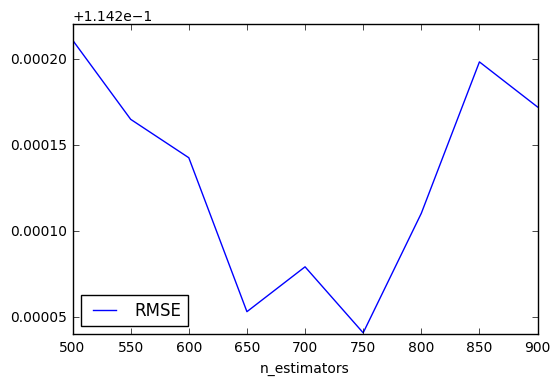

In [83]:
xgb_regr = xgb.XGBRegressor(
    max_depth = 6, 
    min_child_weight = 2.1,
    gamma = 0,
    subsample = 0.8,
    colsample_bytree = 0.08,
    reg_alpha = 0.7,
    reg_lambda = 0.3, 
    learning_rate = 0.09,
    n_estimators = 356,
    objective='reg:linear', 
    seed = 42,
    nthread = -1,
    silent = 1)
xgb_params = {'n_estimators': np.arange(700, 800, 50).tolist()}
xgb_df = single_search(xgb_regr, xgb_params)
xgb_df.plot(x = ['n_estimators'], y = ['RMSE'])
xgb_df.sort_values(['RMSE'], ascending = False)

In [84]:
xgb_regr = xgb.XGBRegressor(
    max_depth = 6, 
    min_child_weight = 2.1,
    gamma = 0,
    subsample = 0.8,
    colsample_bytree = 0.08,
    reg_alpha = 0.7,
    reg_lambda = 0.3, 
    learning_rate = 0.09,
    n_estimators = 750,
    objective='reg:linear', 
    seed = 42,
    nthread = -1,
    silent = 1)

In [85]:
validate(xgb_regr)

0.10718138987821439

## MLP Regressor

In [87]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(100, ),
                        alpha=0.0001, 
                        tol=0.0001, 
                        max_iter=200)

In [88]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641)
mlp_param = {'hidden_layer_sizes': scipy.stats.randint(50,500), # size of a single hidden layer
             'alpha': scipy.stats.expon(scale=0.0001), # L2 regularization,  [0,∞]
             'tol': scipy.stats.expon(scale=0.0001), # Minimum improvement in loss fun. during training
             'max_iter': scipy.stats.uniform(200, 400), # Maximum number of iterations of solver
            }
random_search(mlp_regr, mlp_param, 20)

RandomizedSearchCV took 979.58 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.018 (std: 0.003)
Parameters: {'alpha': 7.9474146542633326e-05, 'max_iter': 254.75766434449292, 'tol': 0.00051370254409097604, 'hidden_layer_sizes': 180}

Model with rank: 2
Mean validation score: -0.019 (std: 0.004)
Parameters: {'alpha': 9.5534191905978234e-05, 'max_iter': 325.29990235345417, 'tol': 7.3917766405963572e-05, 'hidden_layer_sizes': 53}

Model with rank: 3
Mean validation score: -0.019 (std: 0.003)
Parameters: {'alpha': 7.0693444860997102e-05, 'max_iter': 569.45040273601546, 'tol': 9.9294707745904161e-05, 'hidden_layer_sizes': 216}



,max_iter,RMSE,std dev
0,50.0,0.13545419730887231502,0.08852882580343549024
1,75.0,0.12545137226339392322,0.07817996423775047665
2,100.0,0.12014421572863279164,0.07548702134770816918
3,125.0,0.11922258134801191898,0.07485021029348254418
4,150.0,0.11777404905656274625,0.07428916072369949608
5,175.0,0.11704608818323401775,0.07394131807123152655
6,200.0,0.11680280261822281740,0.07411499550049457929
7,225.0,0.11667120942033040731,0.07426111828317717711
8,250.0,0.11650957620607980958,0.07437693978561817076


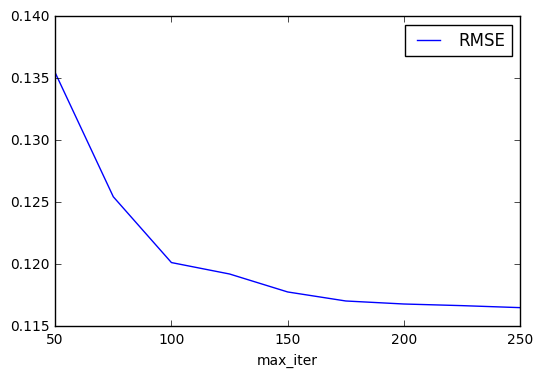

In [99]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(2, ),
                        alpha=0.000005, 
                        tol=0.0004, 
                        max_iter=250)
mlp_params = {'max_iter': np.arange(50, 275, 25).tolist()}
mlp_df = single_search(mlp_regr, mlp_params)
mlp_df.plot(x = ['max_iter'], y = ['RMSE'])
mlp_df.sort_values(['RMSE'], ascending = False)

In [112]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(2, ),
                        alpha=0.000005, 
                        tol=0.0004, 
                        max_iter=250)

In [113]:
validate(mlp_regr)

0.10649203828092935